In [26]:
from datasets import load_dataset

ds = load_dataset("anilguven/turkish_spam_email")

print(ds)

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'labels', 'text'],
        num_rows: 811
    })
    test: Dataset({
        features: ['Unnamed: 0', 'labels', 'text'],
        num_rows: 203
    })
})


In [28]:
import pandas as pd
df_test = pd.DataFrame(ds['test'])
df_train = pd.DataFrame(ds['train'])
# Train setindeki etiket dağılımı
train_label_distribution = df_train['labels'].value_counts()
print("Train seti etiket dağılımı:")
print(train_label_distribution)

# Test setindeki etiket dağılımı
test_label_distribution = df_test['labels'].value_counts()
print("\nTest seti etiket dağılımı:")
print(test_label_distribution)

Train seti etiket dağılımı:
labels
1    412
0    399
Name: count, dtype: int64

Test seti etiket dağılımı:
labels
0    102
1    101
Name: count, dtype: int64


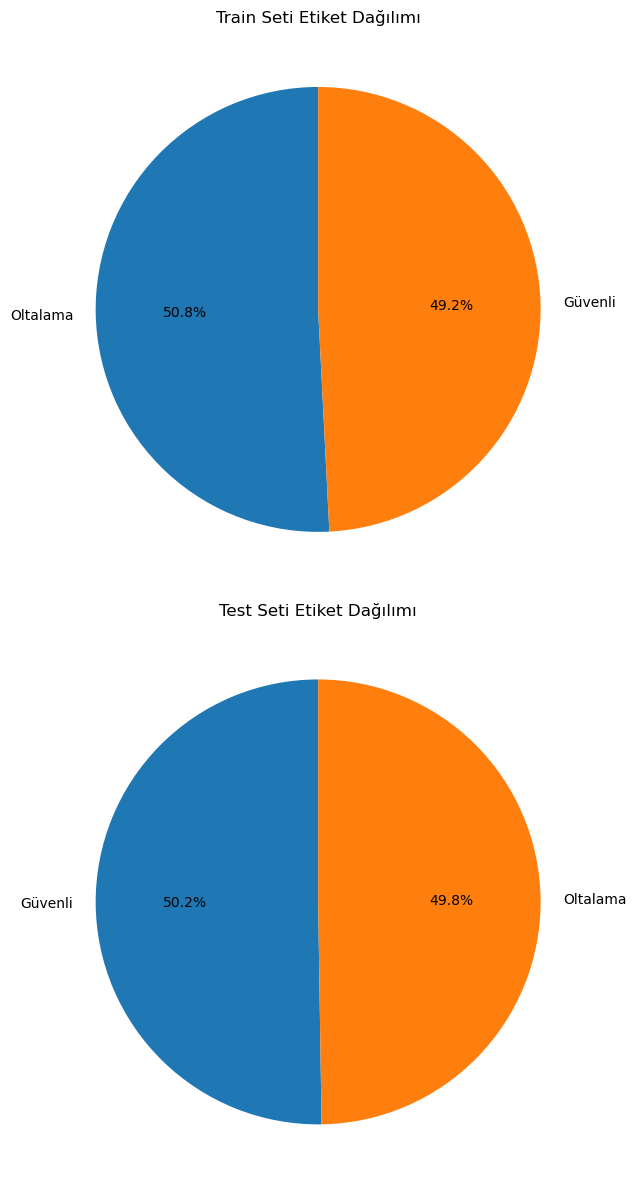

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

train_label_distribution = df_train['labels'].value_counts()

test_label_distribution = df_test['labels'].value_counts()

label_names = {0: 'Güvenli', 1: 'Oltalama'}

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 12))

axes[0].pie(train_label_distribution, labels=[label_names[i] for i in train_label_distribution.index], 
            autopct='%1.1f%%', startangle=90)
axes[0].set_title('Train Seti Etiket Dağılımı')

axes[1].pie(test_label_distribution, labels=[label_names[i] for i in test_label_distribution.index], 
            autopct='%1.1f%%', startangle=90)
axes[1].set_title('Test Seti Etiket Dağılımı')

plt.tight_layout()
plt.show()

In [7]:
import os
print(os.path.dirname(os.getcwd()))

/Users/tczeuslu/Desktop/zgu/courses/data_mining/phishing-mail-detection/src


In [11]:
import pandas as pd

df_test = pd.DataFrame(ds['test'])
df_train = pd.DataFrame(ds['train'])

if 'Unnamed: 0' in df_test.columns:
    df_test = df_test.drop('Unnamed: 0', axis=1)
if 'Unnamed: 0' in df_train.columns:
    df_train = df_train.drop('Unnamed: 0', axis=1)

out_data_dir = os.path.join(os.path.dirname(os.getcwd()), "source", "data", "turkish_spam_email")
os.makedirs(out_data_dir, exist_ok=True)

df_train.to_csv(os.path.join(out_data_dir, "train.csv"), index=False)
df_test.to_csv(os.path.join(out_data_dir, "test.csv"), index=False)

print(f"Train set shape: {df_train.shape}")
print(f"Test set shape: {df_test.shape}")

Train set shape: (811, 2)
Test set shape: (203, 2)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tczeuslu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Train seti wordcloud'ları oluşturuluyor...


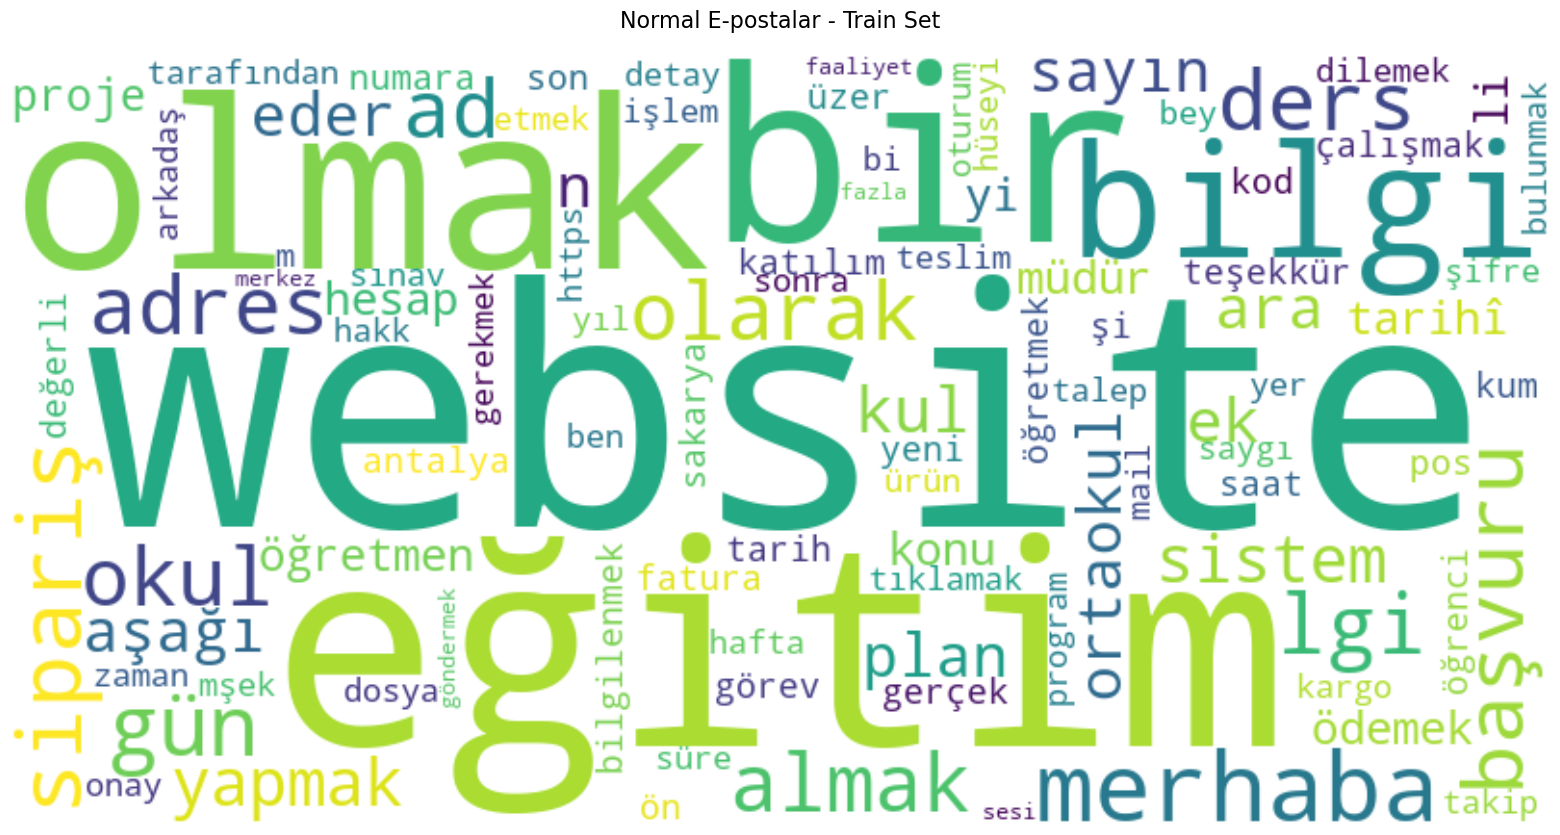

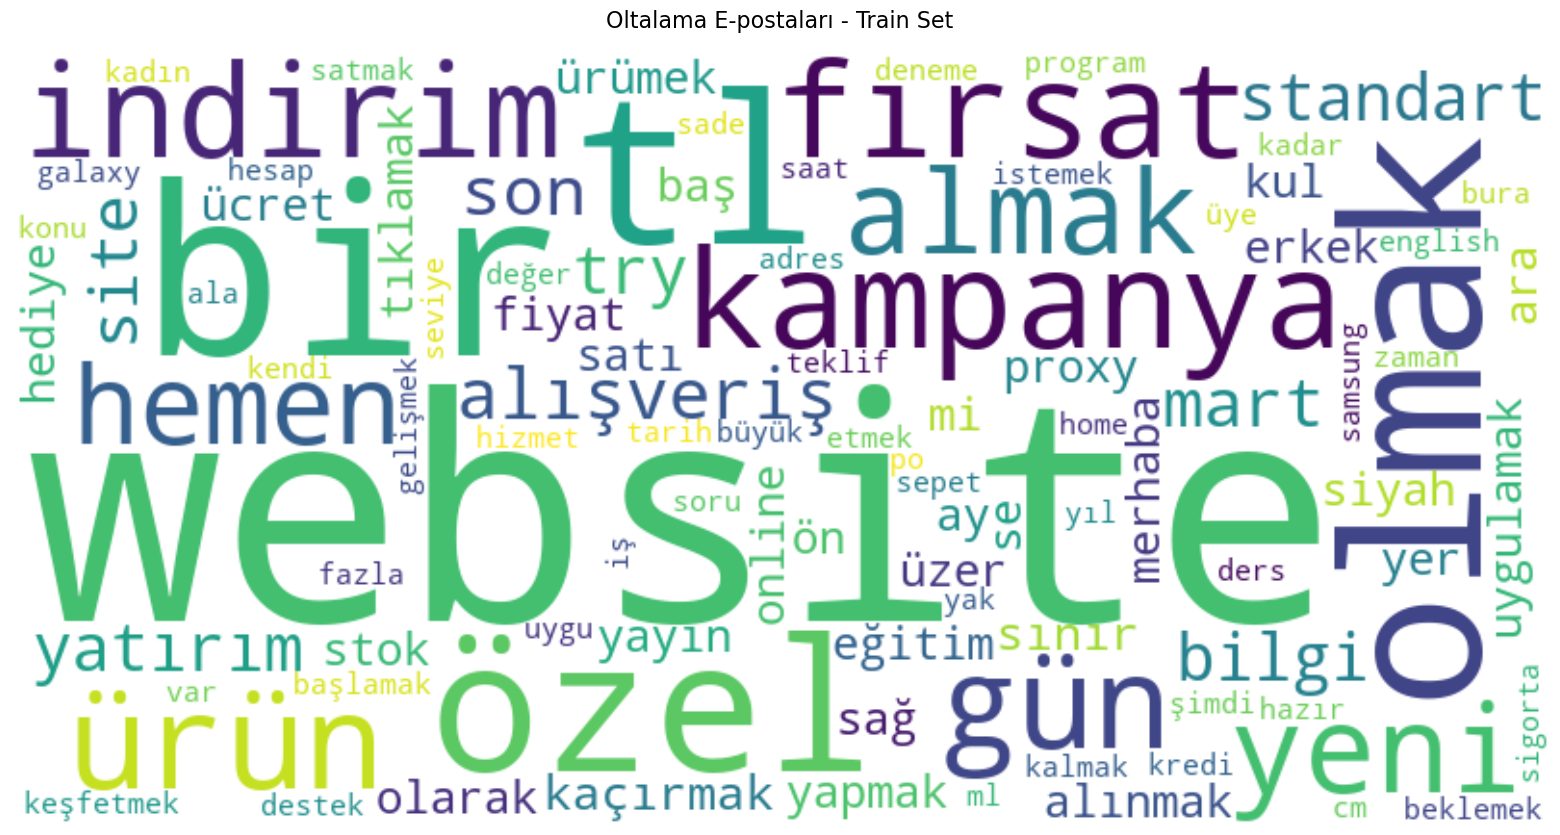


Test seti wordcloud'ları oluşturuluyor...


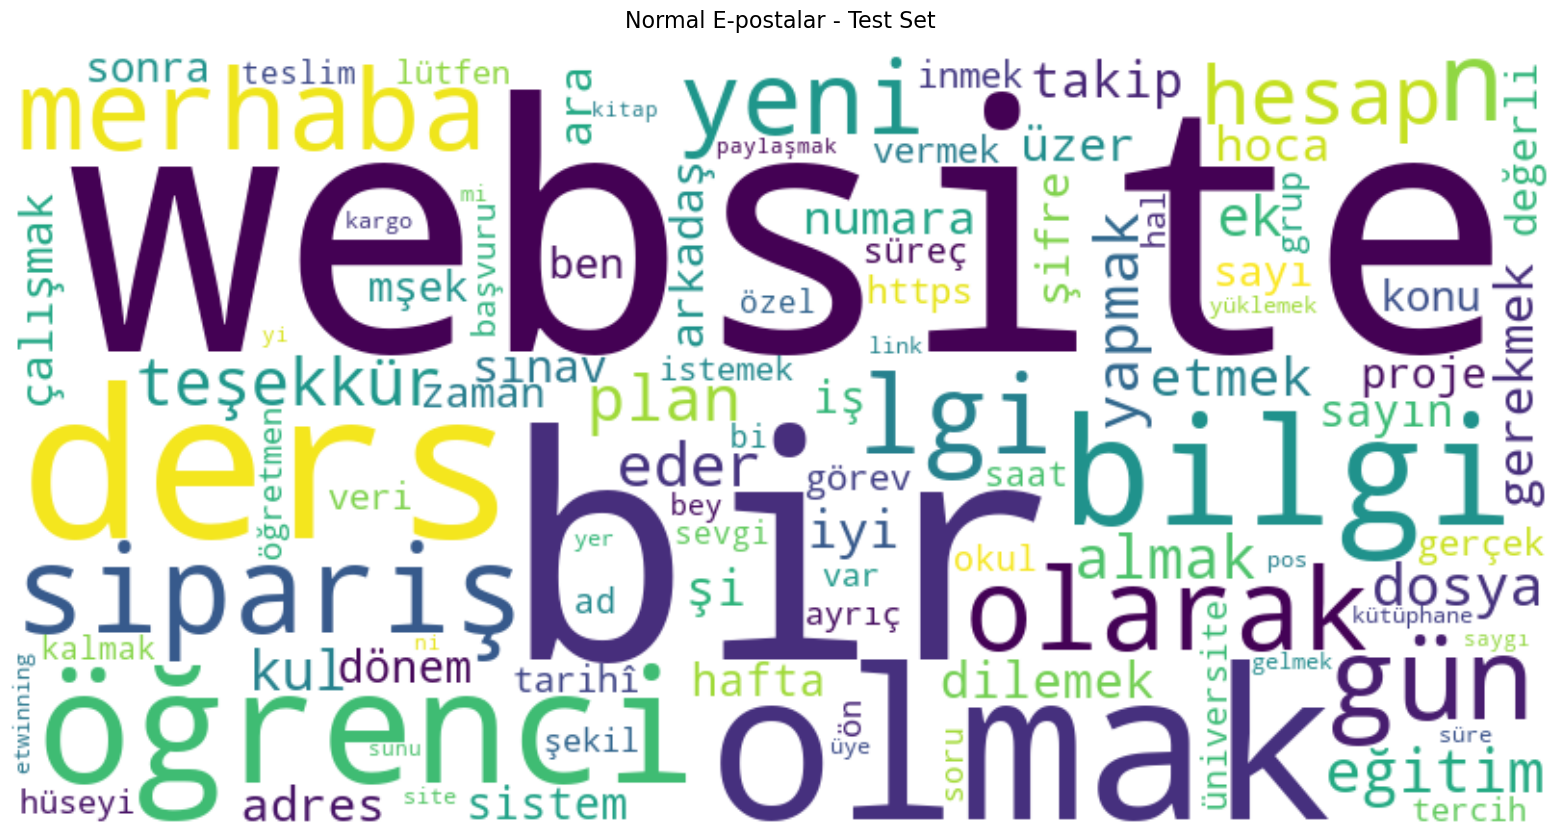

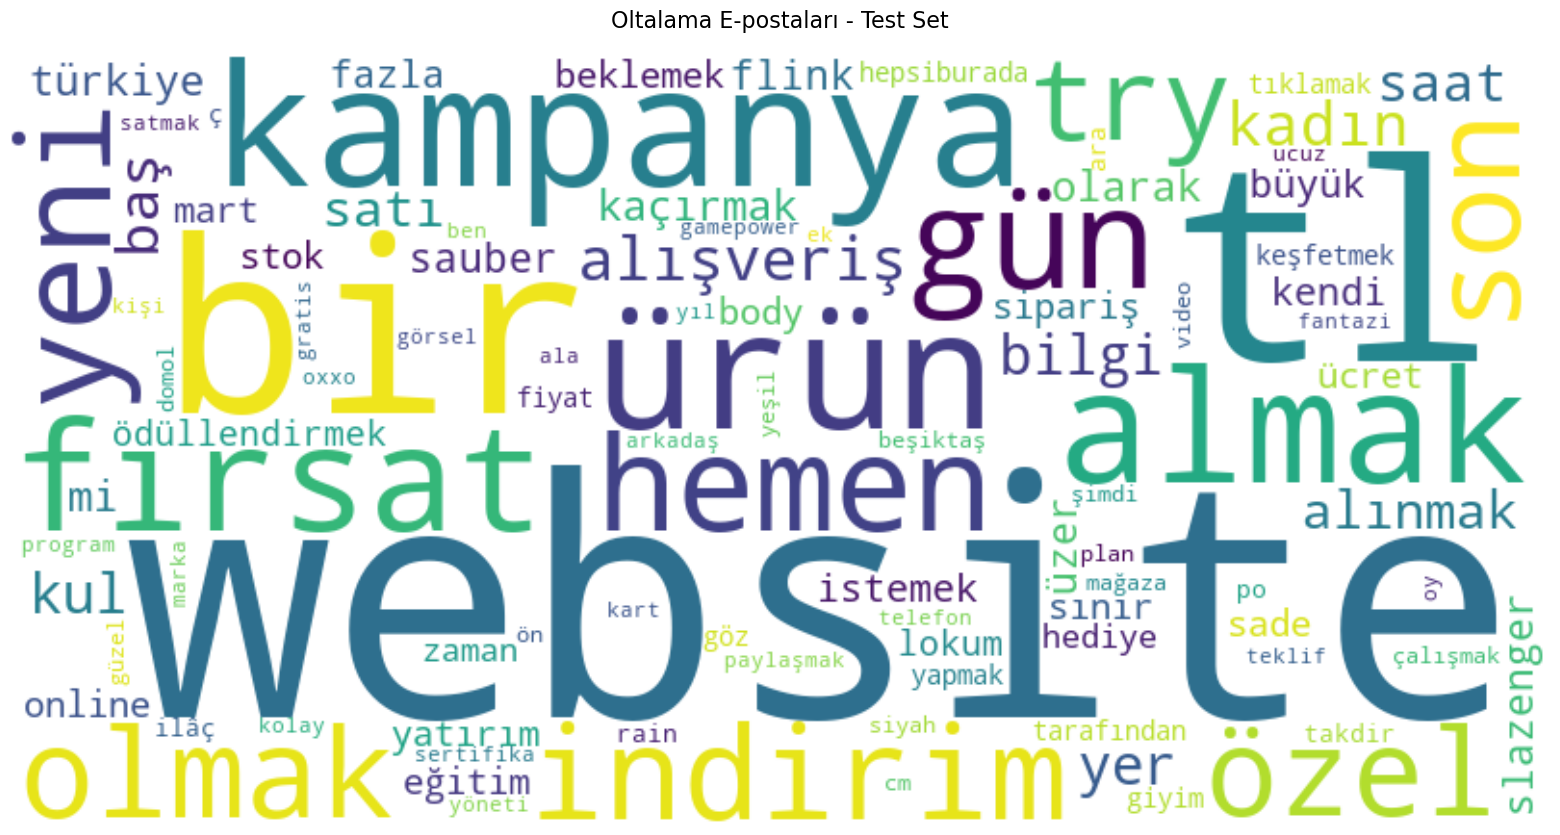

In [18]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import nltk
from nltk.corpus import stopwords
import string
import re

nltk.download('stopwords')
turkish_stop_words = set(stopwords.words('turkish'))

def preprocess_text(text):
    """Metin ön işleme"""
    if isinstance(text, str):
        text = text.lower()
        text = text.translate(str.maketrans('', '', string.punctuation))
        text = re.sub(r'\d+', '', text)
        words = text.split()
        words = [word for word in words if word not in turkish_stop_words]
        return ' '.join(words)
    return ''

def create_wordcloud(texts, title, save_path=None):
    """Wordcloud oluştur"""
    text = ' '.join([preprocess_text(str(text)) for text in texts])
    
    wordcloud = WordCloud(
        width=800, 
        height=400,
        background_color='white',
        max_words=100,
        collocations=False,
        regexp=r"\w+",
        min_font_size=10
    ).generate(text)
    
    plt.figure(figsize=(20,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16, pad=20)
    
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()  
        

print("Train seti wordcloud'ları oluşturuluyor...")

normal_emails = df_train[df_train['labels'] == 0]['text']
create_wordcloud(
    normal_emails, 
    'Normal E-postalar - Train Set',
    'wordcloud_normal_train.png'
)

phishing_emails = df_train[df_train['labels'] == 1]['text']
create_wordcloud(
    phishing_emails, 
    'Oltalama E-postaları - Train Set',
    'wordcloud_phishing_train.png'
)

print("\nTest seti wordcloud'ları oluşturuluyor...")

normal_emails_test = df_test[df_test['labels'] == 0]['text']
create_wordcloud(
    normal_emails_test, 
    'Normal E-postalar - Test Set',
    'wordcloud_normal_test.png'
)

phishing_emails_test = df_test[df_test['labels'] == 1]['text']
create_wordcloud(
    phishing_emails_test, 
    'Oltalama E-postaları - Test Set',
    'wordcloud_phishing_test.png'
)

In [20]:
import pandas as pd
import os

df_train = pd.read_csv(os.path.join(out_data_dir, "train.csv"))
df_test = pd.read_csv(os.path.join(out_data_dir, "test.csv"))

def calculate_word_stats(df, text_column='text', label_column='labels'):
    """Her bir etiket için ortalama kelime sayısı ve kelime uzunluğu hesaplanır"""
    df['word_count'] = df[text_column].apply(lambda x: len(str(x).split()))
    df['char_count'] = df[text_column].apply(lambda x: sum(len(word) for word in str(x).split()))
    
    stats = df.groupby(label_column).agg(
        avg_word_count=('word_count', 'mean'),
        avg_word_length=('char_count', lambda x: x.sum() / df['word_count'].sum())
    ).reset_index()
    
    return stats

train_stats = calculate_word_stats(df_train)
print("Train seti kelime istatistikleri:")
print(train_stats)

test_stats = calculate_word_stats(df_test)
print("\nTest seti kelime istatistikleri:")
print(test_stats)

Train seti kelime istatistikleri:
   labels  avg_word_count  avg_word_length
0       0       43.175439         2.537571
1       1       55.058252         3.157551

Test seti kelime istatistikleri:
   labels  avg_word_count  avg_word_length
0       0       50.333333         2.903444
1       1       51.504950         2.828851


In [25]:
import pandas as pd
import re

# CSV dosyalarını yükle
df_train = pd.read_csv(os.path.join(out_data_dir, "train.csv"))
df_test = pd.read_csv(os.path.join(out_data_dir, "test.csv"))

def count_urls_by_label(df, text_column='text', label_column='labels'):
    """Label bazlı URL içeren ve içermeyen örnek sayısını hesapla"""
    # URL varlığına göre yeni bir sütun ekle
    df['has_url'] = df[text_column].apply(lambda x: 1 if re.search(r'http[s]?://', str(x)) else 0)
    
    # Label bazlı gruplama ve sayma
    url_counts = df.groupby(label_column)['has_url'].value_counts().unstack(fill_value=0)
    
    # Sütun isimlerini kontrol et ve ayarla
    if 0 in url_counts.columns and 1 in url_counts.columns:
        url_counts.columns = ['No URL', 'Has URL']
    elif 0 in url_counts.columns:
        url_counts.columns = ['No URL']
    elif 1 in url_counts.columns:
        url_counts.columns = ['Has URL']
    
    return url_counts

# Train seti için URL sayısı
train_url_counts = count_urls_by_label(df_train)
print("Train seti URL sayıları:")
print(train_url_counts)

# Test seti için URL sayısı
test_url_counts = count_urls_by_label(df_test)
print("\nTest seti URL sayıları:")
print(test_url_counts)

Train seti URL sayıları:
        No URL
labels        
0          399
1          412

Test seti URL sayıları:
        No URL
labels        
0          102
1          101
